In [1]:
#install dependencies
# !pip install pyarrow
# !pip install  duckdb --upgrade --pre
# !pip install wittgenstein


In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split,  GroupShuffleSplit
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, matthews_corrcoef

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler
from sklearn.model_selection import GridSearchCV

import os
import time

## Duck Db imports
import pyarrow.parquet as pq
import duckdb

# developed packages
from utils import create_facts_and_examples, performance_metrics



## Import Data¶


#### create duck db connection

In [3]:
con = duckdb.connect(':memory:')
# enable automatic query parallelization
con.execute("PRAGMA threads=2")
# enable caching of parquet metadata
con.execute("PRAGMA enable_object_cache")

#### Reading PAYSIM1 data and creating parquet file

In [4]:
try:
    con.sql('DROP TABLE df_fraud_tbl')
    print("previous table dropped")
except:
    pass

try:
    con.sql("""CREATE TABLE fraud_tbl AS SELECT * FROM 'fraud.parquet';""")
except:
    con.sql(
    """
    copy 'data/paysim1/PS_20174392719_1491204439457_log.csv' to 'fraud.parquet';
""")
    con.sql("""CREATE TABLE fraud_tbl AS SELECT * FROM 'fraud.parquet';""")

#### Creating externarl origin and destination, Imputing zero values for external accounts

In [5]:
df_fraud = con.sql(""" 
SELECT *,
-- evaluating external accounts
    oldbalanceOrg==0 and newbalanceOrig==0 as external_orig,
    oldbalanceDest==0 and newbalanceDest==0 as external_dest,
-- Imputing zero values for external accounts
    CASE WHEN external_orig==True 
        THEN  amount
        ELSE oldbalanceOrg
    END AS oldbalanceOrg_imputed,
    CASE WHEN external_dest==True 
        THEN  amount
        ELSE newbalanceDest
    END AS newbalanceDest_imputed, 
FROM fraud_tbl
""").df()

# testing
slice_index = df_fraud['external_orig']==True

assert np.sum(df_fraud[slice_index]['amount'] != df_fraud[slice_index]['oldbalanceOrg_imputed'] )==0, "Wrong imputation for external origin"

slice_index = df_fraud['external_dest']==True

assert np.sum(df_fraud[slice_index]['amount'] != df_fraud[slice_index]['newbalanceDest_imputed'] )==0, "Wrong imputation for external destination"


## Split data to train/test/val 

#### train and test sets

In [7]:
gss = GroupShuffleSplit(n_splits=1, test_size=0.15, random_state=42)
for train_index, test_index in gss.split(df_fraud, groups=df_fraud['nameDest']):
    df_train_total = df_fraud.loc[train_index]
    df_test_       = df_fraud.loc[test_index]

#### validation set is a part of train set

In [8]:
df_train_total = df_train_total.reset_index(drop=True)

gss = GroupShuffleSplit(n_splits=1, test_size=0.15, random_state=42)
for train_index, val_index in gss.split(df_train_total, groups=df_train_total['nameDest']):
    df_train_ = df_train_total.loc[train_index]
    df_val_   = df_train_total.loc[val_index]

# Preprocessing

#### aggregation definition
compute average, and maximum amount of transfer for the last 3, and 7 days for the destination 

In [9]:
def aggregates(df):
    """ runs aggregations on pandas dataframe with help of duckdb"""
    data = df.copy()

    data = con.sql("""
        SELECT 
            *,

-- calculate aggregetions (Average and Max) for last 7 including current row for each name Destination
            AVG(amount) OVER (PARTITION BY nameDest ORDER BY step ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS mean_last_7,
            MAX(amount) OVER (PARTITION BY nameDest ORDER BY step ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS max_last_7,
       
-- calculate aggregetions (Average and Max) for last 3 including current row for each name Destination
            AVG(amount) OVER (PARTITION BY nameDest ORDER BY step ROWS BETWEEN 2 PRECEDING AND CURRENT ROW) AS mean_last_3,
            MAX(amount) OVER (PARTITION BY nameDest ORDER BY step ROWS BETWEEN 2 PRECEDING AND CURRENT ROW) AS max_last_3,

-- deviation from the aggregated values
            amount-mean_last_7 as deviation_from_mean_7_days,
            amount-mean_last_3 as deviation_from_mean_3_days,
            amount-max_last_7 as deviation_from_max_7_days,
            amount-max_last_3 as deviation_from_max_3_days,

        FROM 
            data
            ORDER BY step
            """).df()
    
    return data

#### Preprocessing class fit on train data and processes 

In [11]:
class Preprocess:
    def __init__(self, scaler_columns):

        self.scaler = StandardScaler()

        self.scaler_columns = scaler_columns
        
    def fit(self, train_data_frame):
        
        self.scaler.fit(train_data_frame[self.scaler_columns])
        
    def transform(self, data_frame):
        
        df = data_frame.copy()
        
        #scale numerical columns 
        df[self.scaler_columns] = self.scaler.transform(df[self.scaler_columns])
        
        ### run aggregation
        df = aggregates(df)
        
        # one hot encoding and drop columns 
        df['distType'] = df["nameDest"].str[0]
        df = pd.get_dummies(df, columns=['type', "distType"])
        df.drop(columns=["step", "nameOrig", "nameDest", "isFlaggedFraud"], inplace=True)

        
        return df

    
columns = ['amount', 'oldbalanceOrg_imputed', 'newbalanceOrig', 'oldbalanceDest',
   'newbalanceDest_imputed']

preprocessor = Preprocess(scaler_columns=columns)

preprocessor.fit(df_train_)

#### prerocessing 

In [12]:
df_train = preprocessor.transform(df_train_)
df_test = preprocessor.transform(df_test_)
df_val = preprocessor.transform(df_val_)



FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

#### performance

In [16]:
def performance(model, x_test, y_test):
    """ evaluetes performance of the model"""
    y_pred = model.predict(x_test)
    performance_metrics(y_pred, y_test, labels=model.classes_)

In [13]:
df_train

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,external_orig,external_dest,oldbalanceOrg_imputed,newbalanceDest_imputed,...,deviation_from_mean_3_days,deviation_from_max_7_days,deviation_from_max_3_days,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,distType_C,distType_M
0,0.310698,0.00,-0.292488,-0.215996,16518.36,0,True,False,-0.184448,-0.333088,...,0.000000,0.000000,0.000000,False,False,False,False,True,True,False
1,-0.194636,582158.41,-0.072384,-0.274765,16518.36,0,False,False,-0.110952,-0.333088,...,-0.252667,-0.505334,-0.505334,True,False,False,False,False,True,False
2,0.000526,0.00,-0.292488,0.098040,16518.36,0,True,False,-0.248690,-0.333088,...,-0.038337,-0.310172,-0.310172,False,False,False,False,True,True,False
3,-0.053805,0.00,-0.292488,-0.259437,16518.36,0,True,False,-0.259944,-0.333088,...,0.028833,-0.364503,-0.054331,False,False,False,False,True,True,False
4,0.742608,2726760.74,0.853243,0.112000,16518.36,0,False,False,0.624242,-0.333088,...,0.512831,0.000000,0.000000,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4599525,1.108862,850002.52,-0.292488,-0.325159,0.00,1,False,True,-0.019132,-0.105975,...,0.000000,0.000000,0.000000,False,False,False,False,True,True,False
4599526,1.108862,850002.52,-0.292488,1.591606,7360101.63,1,False,False,-0.019132,1.667936,...,0.762928,0.000000,0.000000,False,True,False,False,False,True,False
4599527,1.785510,1258818.82,-0.292488,-0.176925,1762283.33,1,False,False,0.121014,0.142609,...,1.094290,0.000000,0.000000,False,True,False,False,False,True,False
4599528,10.148242,6311409.28,-0.292488,-0.325159,0.00,1,False,True,1.853100,1.382182,...,0.000000,0.000000,0.000000,False,False,False,False,True,True,False


## Decision Tree

In [15]:
X_train = df_train.drop(columns=['isFraud'])
y_train = df_train['isFraud']
X_test = df_test.drop(columns=['isFraud'])
y_test = df_test['isFraud']

X_val = df_val.drop(columns=['isFraud'])
y_val = df_val['isFraud']

In [19]:
# hyper parameter tuning

dtc_model=DecisionTreeClassifier(random_state=42)

parameters = {'max_leaf_nodes': range(3,9,1)}
gs_clf = GridSearchCV(dtc_model, parameters, cv=5, scoring='matthews_corrcoef')

features = ['amount', 'external_dest', 'oldbalanceOrg_imputed', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest_imputed', 'deviation_from_max_7_days',
       'deviation_from_max_3_days', 'type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT',
       'type_PAYMENT', 'type_TRANSFER']

gs_clf.fit(X_val[features], y_val)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_leaf_nodes': range(3, 9)},
             scoring='matthews_corrcoef')

In [21]:
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))
print('grid search score, cv=5,', gs_clf.best_score_)

max_leaf_nodes: 8
grid search score, cv=5, 0.5061408455889455


In [22]:
dtc_model=gs_clf.best_estimator_
dtc_model.fit(X_train[features],y_train)
dtc_prediction=dtc_model.predict(X_test[features])

In [32]:
predicates = dtc_model.feature_names_in_[dtc_model.feature_importances_!=0]

array(['amount', 'external_dest', 'oldbalanceDest', 'type_TRANSFER'],
      dtype=object)

In [24]:
dtc_model.feature_names_in_

array(['amount', 'external_dest', 'oldbalanceOrg_imputed',
       'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest_imputed',
       'deviation_from_max_7_days', 'deviation_from_max_3_days',
       'type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT',
       'type_TRANSFER'], dtype=object)

Accuracy: 0.999528
Precision TP/(TP+FP): 0.971098
Recall TP/(TP+FN): 0.665083
F1 Score: 0.789474
MCC Score: 0.803454


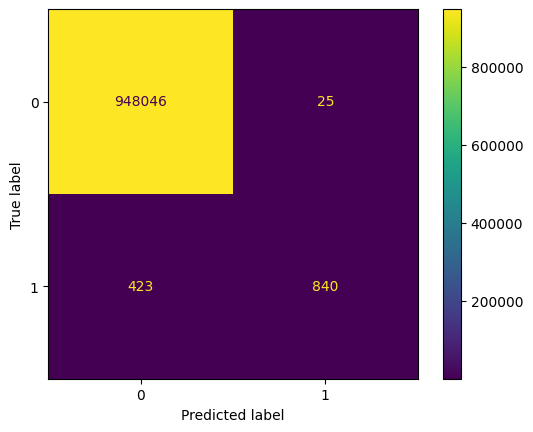

In [25]:
performance(dtc_model, x_test=X_test[features], y_test=y_test)

In [26]:
X_test.columns

Index(['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'external_orig', 'external_dest',
       'oldbalanceOrg_imputed', 'newbalanceDest_imputed', 'mean_last_7',
       'max_last_7', 'mean_last_3', 'max_last_3', 'deviation_from_mean_7_days',
       'deviation_from_mean_3_days', 'deviation_from_max_7_days',
       'deviation_from_max_3_days', 'type_CASH_IN', 'type_CASH_OUT',
       'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER', 'distType_C',
       'distType_M'],
      dtype='object')

[Text(0.5769230769230769, 0.9, 'amount <= 3.079\ngini = 0.003\nsamples = 4599530\nvalue = [4593585, 5945]\nclass = y[0]'),
 Text(0.3076923076923077, 0.7, 'max_last_3 <= 0.5\ngini = 0.002\nsamples = 4568369\nvalue = [4563640.0, 4729.0]\nclass = y[0]'),
 Text(0.15384615384615385, 0.5, 'amount <= 1.297\ngini = 0.001\nsamples = 4213050\nvalue = [4210651, 2399]\nclass = y[0]'),
 Text(0.07692307692307693, 0.3, 'gini = 0.001\nsamples = 4212296\nvalue = [4210301, 1995]\nclass = y[0]'),
 Text(0.23076923076923078, 0.3, 'newbalanceDest <= -0.007\ngini = 0.497\nsamples = 754\nvalue = [350, 404]\nclass = y[1]'),
 Text(0.15384615384615385, 0.1, 'gini = 0.138\nsamples = 348\nvalue = [26.0, 322.0]\nclass = y[1]'),
 Text(0.3076923076923077, 0.1, 'gini = 0.322\nsamples = 406\nvalue = [324, 82]\nclass = y[0]'),
 Text(0.46153846153846156, 0.5, 'oldbalanceOrg <= 0.5\ngini = 0.013\nsamples = 355319\nvalue = [352989, 2330]\nclass = y[0]'),
 Text(0.38461538461538464, 0.3, 'gini = 0.0\nsamples = 352934\nvalue 

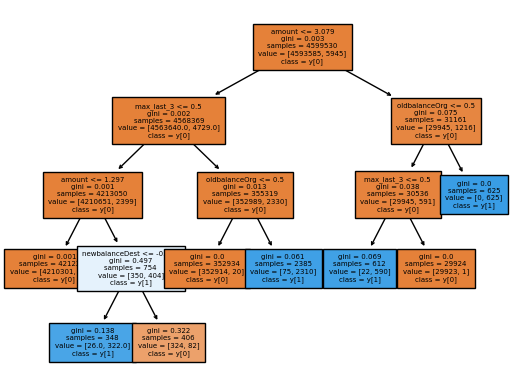

In [27]:
plot_tree(dtc_model, feature_names=X_test.columns, filled=True, fontsize=5, class_names=True)

## Prepare background knowledge, positive, and negative examples for DILP

In [28]:
df_train.iloc[685]

amount                       -0.290765
oldbalanceOrg                   9809.0
newbalanceOrig               -0.290633
oldbalanceDest               -0.325159
newbalanceDest                     0.0
isFraud                              0
external_orig                    False
external_dest                     True
oldbalanceOrg_imputed         -0.30716
newbalanceDest_imputed       -0.336396
mean_last_7                  -0.290765
max_last_7                   -0.290765
mean_last_3                  -0.290765
max_last_3                   -0.290765
deviation_from_mean_7_days         0.0
deviation_from_mean_3_days         0.0
deviation_from_max_7_days          0.0
deviation_from_max_3_days          0.0
type_CASH_IN                     False
type_CASH_OUT                    False
type_DEBIT                       False
type_PAYMENT                      True
type_TRANSFER                    False
distType_C                       False
distType_M                        True
Name: 685, dtype: object

In [29]:
df_1 = df_train[df_train['isFraud']==0]
df_2 = df_train[df_train['isFraud']==1]
fraud_background = pd.concat([df_1.iloc[0:100], df_2.iloc[0:100]], ignore_index=True)
#  type = transfer, and
# • externalDest = True, and
# • amount - maxDest7 > -0.15
fraud_background['deviation_from_max_7_days'] = fraud_background['deviation_from_max_7_days']>-0.15
predicates=['external_dest', 'type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT',
                                       'type_TRANSFER', 'deviation_from_max_7_days']

create_facts_and_examples(df_=fraud_background, target='isFraud', 
                          predicates=predicates, output_dir='examples/fraud')

isFraud
[100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117
 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135
 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153
 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171
 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189
 190 191 192 193 194 195 196 197 198 199]
external_dest
[ 30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  65
  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  87  88  89
  90  91  92  93  94  95  96  97  98  99 101 102 104 106 107 108 110 111
 112 116 117 118 119 120 121 126 127 129 130 132 133 137 138 142 145 147
 148 149 155 156 159 164 169 173 176 177 179 185 186 189 191 197 199]
type_CASH_IN
[ 1  4  5  6  8  9 10 14 15 17 18 20 25 26 45 47 48 53 54 55 56 58 60 63
 81 86]
type_CASH_OUT
[ 12  16  21  29  52  57  59  61  62  82  83 100 103 105 109 113 114 115
 122 123 124 125 128 131 134

In [ ]:
assert 0, "break before ripper"

## RIPPER

In [ ]:
import wittgenstein as lw

In [ ]:
#https://pypi.org/project/wittgenstein/
#https://www.geeksforgeeks.org/ripper-algorithm/
#https://github.com/imoscovitz/wittgenstein#useful-references
ripper_clf = lw.RIPPER() # Or irep_clf = lw.IREP() to build a model using IREP
ripper_clf.fit(X_train,y_train) # Or pass X and y data to .fit
ripper_clf

In [ ]:
ripper_clf.out_model()

In [ ]:
performance(ripper_clf, x_test=X_test, y_test=y_test)